# Image classification with MNIST data, with visualization of the results

This notebook shows how to train a convolutional image recognition network for recognizing hand-written digits. This is the "hello world" example of deep learning, and later on we will also have some artistic use for it. 

**Learning goals:**
* Building a simple convolutional neural network
* Useful debugging skills: visualizing errors, visualizing neural network weights

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**

* Easy: try adding 1 or more fully connected layers, e.g., with 64 neurons before the output layer of the fully connected network example. How do the first layer weights look like now?
* Easy: Pass in an artificial image and check what class it is classified into. Hint: you can "paint" rectancles by first creating an empty single image batch as ```image=np.zeros([1,28,28,1])```, and then setting rectangular patches to 1 as ```image[0,y0:y1,x0:x1,0]=1```, where x0,x1,y0,y1 are the rectangle corners. Feel free to also explore more sophisticated drawing methods, e.g., from the skimage library. 
* Easy: Visualize the test image (or multiple images) that gives the lowest probability for the correct class. Hint: if you pass a batch of test images to model.predict(), you will get a batch of probabilities back, one vector of 10 probabilities for each image.
* Harder: Visualize how well the network learns features that make the number classes separate. Use principal component analysis (PCA) of the flattened layer outputs, and make a 2D scatterplot of each input image's projection into the 2D subspace defined by the first two principal axes. Numpy provides easy helpers for PCA, just google it up. Do the same for different layer outputs; you should see that the classes overlap less and less as the images pass through the network and training progresses.
* Advanced: Develop a game where the player has to draw images that score high classification probabilities with as few pixels as possible. For this, you should either load the network to Unity using Tensorflow Sharp, or experiment with Python's mouse input etc. Obviously, such interaction is not possible inside Jupyter, so you should develop using some other IDE such as Visual Studio, Pycharm, or Spyder (the latter is included in Anaconda)

As usual, model solutions are provided for the easy exercises, but please try to think of this as a puzzle game where you first try to solve the puzzles yourself and only check out the walkthrough if necessary.

## Loading and visualizing the data

First, let's load the dataset using keras helpers and visualize some images using pyplot

c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib
shape:  (60000, 28, 28)
new shape:  (60000, 28, 28, 1)


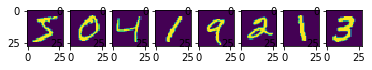

In [1]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras 

#load the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#Scale the pixel intensity values to 0...1 from 0...255
#Fortunately, we don't a StandardScaler here
x_train, x_test = x_train / 255.0, x_test / 255.0

#check the shape: you should see that x_train is a 3D tensor, 
#with 60000 instances of 2D tensors 28x28 pixels 
print("shape: ",x_train.shape)

#because the keras layers we will use need explicitly defined pixel channel count as the fourth dimension,
#we reshape:
x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
print("new shape: ",x_train.shape)

#do the same for test data
x_test=np.reshape(x_test,[x_test.shape[0],x_test.shape[1],x_test.shape[2],1])


#visualize some of the images
pp.figure(1)
for i in range(8):
    pp.subplot(1,8,1+i)
    #imshow expects a 2d tensor, thus we pick the i:th image, full width and height, and the first and only color channel
    pp.imshow(x_train[i,:,:,0])


# Exercise 1: Adding more layers to the fully connected network
The first exercise was to simply add more layers. We only need one line of code per layer

In [2]:
#Let's import the layer types we need
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Flatten #converts images to vectors of numbers

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Flatten converts a batch of multidimensional data into a batch of 1D data. 
#This is what the fully connected layers expect.
#For example, the rows of an image are simply stacked after each other.
#If the data was not images, we would not need this.
model.add(Flatten())

#This is the extra layer. You can try modifying the neuron and layer counts and see how the neuron weights and classification accuracy change
model.add(Dense(64, activation='relu'))

#The output layer is fully connected, with 1 neuron for each 10 classes.
#For classification, one should use the softmax activation.
#This means that each output neuron can be thought as the probability of a class.
model.add(Dense(10, activation='softmax'))

#Compile the model. We use sparse_categorical_crossentropy loss instead of categorical_crossentropy,
#because the label data contains indices instead of one-hot vectors
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.3030 - acc: 0.9147 - val_loss: 0.1657 - val_acc: 0.9521

We can visualize the first layer weights similar to before. Note that for the second layer, we will have as many inputs as the previous layer has neurons, and the input tensors can no longer be interpreted as images. You could, however, try investigating those weights by synthesizing (optimizing) an input image that maximally excites a neuron. This is one of the exercises in the [Adversarial MNIST](AdversarialMNIST.ipynb) tutorial.

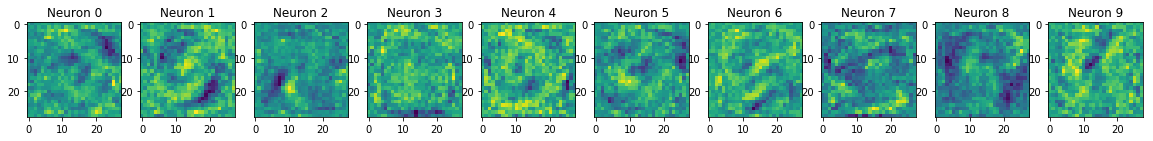

In [3]:
#Visualize some of the first layer neuron weights
#First, query the weights. We use index 1 because index 0 is the flatten layer
weights=model.layers[1].get_weights()[0]
#Create a figure with appropriate size
nNeuronsToVisualize=10
pp.figure(1,figsize=[nNeuronsToVisualize*2,2])
#Loop over the neurons
for i in range(nNeuronsToVisualize):
    #Weights is a 2D tensor where the first dimension indexes over data variables, second over neurons
    image=weights[:,i]
    #We must reshape back to an image
    image=np.reshape(image,[28,28])
    #Now we can display
    pp.subplot(1,nNeuronsToVisualize,1+i)
    pp.title("Neuron {}".format(i))
    pp.imshow(image)  

## A convolutional neural network 

For the rest of the exercises, we again train a convolutional neural network, which gives better classification accuracy.

In [4]:
#Let's import the layer types we need
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Conv2D  #convolutional layer with 2D filters (for audio you would use 1D)
from tensorflow.keras.layers import Dropout #this mitigates overfitting

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Instead of using fully connected layers like before, we use convolutional ones.
#We use 5x5 pixel features, and use strides of 2x2 to drop resolution by a factor of 2 after each layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=[2,2],
                 activation='relu',
                 input_shape=(28,28,1,)))
model.add(Conv2D(32, (5, 5), activation='relu', strides=[2,2]))
#After the previous two layers, we are at 7x7 pixel resolution instead of the original 28x28 pixels.
#Thus, 5x5 filters would not be meaningful, as they would encompass almost the whole images
model.add(Conv2D(32, (3, 3), activation='relu', strides=[2,2]))

#Now, we are at 3x3 pixel resolution and there's no point in doing convolutions anymore.
#Instead, we'll just add a small fully connected layer just like above
#Again, we first need to flatten from a batch of images to a batch of 1D tensors
model.add(Flatten())
#Some regularization
model.add(Dropout(0.5))
#One fully connected
model.add(Dense(32, activation='relu'))
#More regularization
model.add(Dropout(0.5))
#Last fully connected layer, with softmax activation, which is what one needs for classification.
#Softmax means that each output neuron can be thought as the probability of a class.
#We use 10 neurons because MNIST has 10 classes.
model.add(Dense(10, activation='softmax'))

#Compile the model. We use sparse_categorical_crossentropy loss instead of categorica_crossentropy,
#because the label data contains indices instead of one-hot vectors
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 189us/sample - loss: 1.0225 - acc: 0.6499 - val_loss: 0.2621 - val_acc: 0.9402

Let's test the classifier with an images. 

Testing with image:


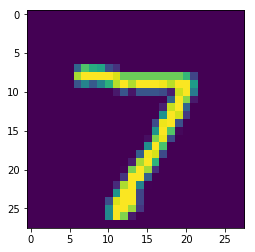

Predicted class probabilities:  [[3.1212148e-14 1.6445136e-14 2.1771283e-09 5.6882840e-12 2.8938720e-15
  1.2791610e-15 3.8051342e-19 1.0000000e+00 3.4598558e-21 3.4779363e-11]]
Most probable class is 7, with probability 1.0


In [5]:
#this is the test image
testIdx=0
#Show the image
print("Testing with image:")
pp.imshow(x_test[testIdx,:,:,0])
pp.show()
#We index by testIdx:testIdx+1 to pass a batch of one image to the network instead of just one image
classProbabilities=model.predict(x_test[testIdx:testIdx+1])
print("Predicted class probabilities: ",classProbabilities)
#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
print("Most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


# Exercise 2: Test the classifier with synthetic images
The second exercise was to create an artificial image, to practice a bit more Numpy tensor manipulation. You could also consider using a Python library for drawing lines etc. into Numpy arrays, e.g., skimage

Here, we simply use np.zeros() to create images with all pixels zero, and then use tensor indexing to set some pixels to 1.

Predicted class probabilities:  [[2.2637060e-07 9.9884272e-01 3.3291053e-05 1.5031284e-04 5.7841222e-05
  2.2898496e-06 6.9191069e-06 7.1927643e-04 2.3215227e-05 1.6378307e-04]]
Most probable class is 1, with probability 0.998842716217041


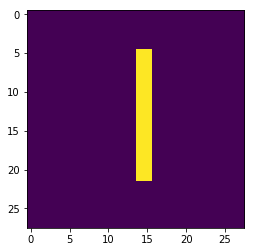

In [9]:
#MNIST images are 28x28 pixels
image1=np.zeros([28,28])
#Draw a vertical bar. Note: The usual convention expected by Numpy and Tensorflow is that 
#in 2D tensors representing images, the first dimension denotes vertical position and second denotes horizontal
image1[5:22,14:16]=1
#Visualize
pp.imshow(image1)
#Test classification. 
#Note: we reshape the single image into a batch. (Try running the code without to see what error you get!) 
#Reshaping does not change Tensor contents,
#it just changes the way contents are indexed
classProbabilities=model.predict(np.reshape(image1,[1,28,28]))
print("Predicted class probabilities: ",classProbabilities)
#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
print("Most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


**Try changing the position of the number vertically or horizontally and running the code again!** Does it affect the classification? 

Theory says that a fully connected network is more sensitive to the position, but a convolutional neural network should care less about it.

You can change what network you use by re-running one of the network building and training cells above.

Also, **try drawing different numbers or patterns.** Can you fool the network with something that doesn't look like a number? This is called an adversarial attack, and neural networks are quite prone to them, it trained with too little data that does not contain all the possible types of images and variations the network will be tested with

# Exercise 3: Visualize the images with largest classification errors
This is a good way to gain insights into both 1) the quality of your dataset, and 2) what the network learns.

There is a few ways to do this. The most simple is to pass images through the network, get the class probabilities out, and compare them to the correct classes. Basically, we can visualize the images for which the probability of the correct class is lowest. 

An alternative is to query the loss function values from the network, but this will require either [overriding some Keras callbacks](https://stackoverflow.com/questions/48118111/get-loss-values-for-each-training-instance-keras) or building the network a bit differently, (see the next cell)

We begin by computing the predicted class probabilities and the real class probabilities in the same format, as a batch of 1D tensors representing discrete probability distributions. The real probabilities are one-hot vectors, i.e., the probability of the correct class is 1, while all other classes have a zero probability.

In [11]:
#a helper to convert the y_test class number array to one-hot
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
realProbabilities=one_hot(y_test,10)
print(realProbabilities)

#pass the whole test data through the network
predictedProbabilities=model.predict(x_test)
print(predictedProbabilities)


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[5.7225851e-08 1.0453528e-09 1.3753230e-05 ... 9.9864465e-01
  1.6029279e-06 4.9798214e-06]
 [3.1986784e-07 5.4834527e-04 9.9832827e-01 ... 1.1983819e-12
  3.4183868e-05 1.0169169e-10]
 [1.6703903e-05 9.9778640e-01 4.8023681e-04 ... 4.1405240e-04
  1.1327808e-03 1.5038080e-05]
 ...
 [6.6602115e-09 1.8201685e-09 3.4927292e-09 ... 6.9776790e-05
  1.0179833e-04 4.0976732e-04]
 [1.0252538e-08 1.0008708e-10 1.2945209e-11 ... 4.4396792e-10
  2.4819998e-05 1.9784771e-11]
 [2.9506463e-08 1.1271903e-09 3.3119230e-07 ... 6.0719415e-13
  3.9083708e-10 9.7857581e-12]]


To figure out which predicted probabilities differ most from the actual probabilities, we now need some distance measure between probability distributions. The softmax cross-entropy used in the training is exactly that, but for the purpose of visualization, we can simplify a bit. Here, we just multiply the tensors together.

You should see that the result is something like a one-hot distribution, but for some images, the probability of the correct class is less than 1. These are the non-confident predictions we are interested about.

In [17]:
product=realProbabilities*predictedProbabilities
print(product)

[[0.         0.         0.         ... 0.99864465 0.         0.        ]
 [0.         0.         0.99832827 ... 0.         0.         0.        ]
 [0.         0.9977864  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Now, we can collapse along the second dimension to get only the non-zero elements

In [18]:
collapsed=np.max(product,axis=1)
print(collapsed)

[0.99864465 0.99832827 0.9977864  ... 0.9994179  0.9999752  0.99994743]


The 1D tensor above now contains the correct class probability for each test image. We can now find the minimum and display the corresponding image.

Correct class 6, probability 7.365336500697595e-07


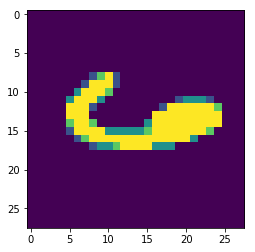

In [20]:
index=np.argmin(collapsed)
print("Correct class {}, probability {}".format(y_test[index],collapsed[index]))
pp.imshow(x_test[index,:,:,0])